# Producing uplifted single peaked events


In [85]:
from datetime import datetime, timedelta
import pandas as pd
from dateutil.relativedelta import relativedelta
import sys
import matplotlib.patches as mpatches
from matplotlib import dates as mdates
import re
sys.path.insert(1, '../')
from Functions import *

In [86]:
catchment_rainfall = {'LinDyke':59.29,
                     'WykeBeck':59.25}

In [87]:
catchment_name = 'WykeBeck'

### Define the different methods 

In [88]:
percent_increases =['0', '05','10','15', '20','30']
method = 'single-peak'
duration = '6h'
N_subpeaks = 1
default_peak_shape='refh2-summer'
total_duration_minutes = (int(duration[0]) * 60) +1
subpeak_duration_minutes=total_duration_minutes/6
peak_before_frac = 0.5

In [89]:
# Create datetimes to go with values
start = datetime(2022,8,1,0,0,0)
end = start + relativedelta(hours=int(duration[0]))
end = end - timedelta(minutes=1) 

if total_duration_minutes == (int(duration[0]) * 60) +1:
    seconds = (end - start).total_seconds() + 61
else:    
    seconds = (end - start).total_seconds() + 60 
step = timedelta(minutes=1)
datetimes = []
for i in range(0, int(seconds), int(step.total_seconds())):
    datetimes.append(start + timedelta(seconds=i))       

### Create a single peaked profile with 10% extra volume

In [90]:
for percent_increase in percent_increases:

    # Find the multiplier and use to multiply the total event accumulation
    multiplier = np.float64('1.{}'.format(percent_increase))
    total_mm_accum=  catchment_rainfall[catchment_name] * multiplier

    # Find accumulation and rate
    accum, rate = calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes,peak_before_frac)
    # Create as dataframe
    accum_df = pd.DataFrame({'Dates': datetimes,  'Rate (mm/hr)': rate, 'Rate (mm/min)': rate/60})
    # Keep only columns needed for feeding to ReFH2
    accum_df = accum_df[['Dates','Rate (mm/min)']]

    # Write to csv
    if percent_increase == '05':
        percent_increase = '5'
    accum_df.to_csv("{}/{}r_100yrRP/PreLossRemoval/{}_sp_+{}%volume.csv".format(catchment_name, duration,duration, percent_increase),
                   header = False, index = False)
    
    if percent_increase == '0':
        all_accums = accum_df.copy()
        all_accums.rename(columns ={'Rate (mm/min)':percent_increase}, inplace = True)
    else:
        all_accums[percent_increase] = accum_df['Rate (mm/min)']
    
    print("Percent increase in volume:" + percent_increase+ '%' + '. New total volume: ' + str(total_mm_accum))
    print("Maximum rate (mm/min): " + str(round(all_accums[percent_increase].max(),3)))

Percent increase in volume:0%. New total volume: 59.25
Maximum rate (mm/min): 1.236
Percent increase in volume:5%. New total volume: 62.212500000000006
Maximum rate (mm/min): 1.298
Percent increase in volume:10%. New total volume: 65.17500000000001
Maximum rate (mm/min): 1.36
Percent increase in volume:15%. New total volume: 68.13749999999999
Maximum rate (mm/min): 1.422
Percent increase in volume:20%. New total volume: 71.1
Maximum rate (mm/min): 1.484
Percent increase in volume:30%. New total volume: 77.025
Maximum rate (mm/min): 1.607


In [91]:
for col_num, percent_increase in enumerate(percent_increases):
    if percent_increase == '05':
        percent_increase = '5'
    post_loss_removal = pd.read_csv("{}/6hr_100yrRP/PostLossRemoval/6h_sp_+{}%_urban.csv".format(catchment_name, percent_increase))
    print("Maximum rate (mm/min): " + str(round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].max(),5)))
    print("Maximum rate (mm/min): " + str(round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].sum(),3)))

Maximum rate (mm/min): 0.41886
Maximum rate (mm/min): 20.068
Maximum rate (mm/min): 0.70567
Maximum rate (mm/min): 33.811
Maximum rate (mm/min): 0.4721
Maximum rate (mm/min): 22.618
Maximum rate (mm/min): 0.49949
Maximum rate (mm/min): 23.931
Maximum rate (mm/min): 0.5274
Maximum rate (mm/min): 25.268
Maximum rate (mm/min): 0.58476
Maximum rate (mm/min): 28.017


### Check what the percentage variation is in the other metrics

In [92]:
# previous = 14.7
# for current in [15.615, 16.594, 18.616]:
#     print(((float(current)-previous)/previous)*100)
    
# previous = 1.096
# for current in [1.15,1.205,1.315]:
#     print(((float(current)-previous)/previous)*100)

# previous = 0.269
# for current in [0.287, 0.305, 0.342]:
#     print(((float(current)-previous)/previous)*100)

## Pre and post loss removal: plot single peak profiles with scaled volumes

In [93]:
colors =['#90b4d7', '#7390c8', '#566cb8', '#3a48a9', '#1d249a', '#00008b']

In [94]:
# fig,axs=plt.subplots(1,3, figsize=(12,3))
# for col_num, percent_increase in enumerate(percent_increases):
#     if percent_increase=='05':
#         percent_increase = 5
#     # Read in post loss removal rainfall rate
#     pre_loss_removal = pd.read_csv("{}/6hr_100yrRP/PreLossRemoval/6h_sp_+{}%volume.csv".format(catchment_name, percent_increase), names =['Time', 'Rain'])
#     post_loss_removal = pd.read_csv("{}/6hr_100yrRP/PostLossRemoval/6h_sp_+{}%volume.csv".format(catchment_name, percent_increase))
#     # Find cumulative rainfall rate
#     post_loss_removal['cumulative_rainfall_this_min'] = post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].cumsum()

#     # PLot
#     axs[0].plot(range(total_duration_minutes), pre_loss_removal['Rain'], color = colors[col_num])
#     axs[0].set_xlabel('Time [mins]', fontsize = 9)
#     axs[0].set_title('Rainfall rate [mm/min] \n pre loss removal')
    
#     axs[1].plot(np.array(range(total_duration_minutes)) , post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'],
#                colors[col_num])
#     axs[1].set_xlabel('Time [mins]', fontsize = 9)
#     axs[1].set_title('Rainfall rate [mm/min] \n post loss removal')
    
#     axs[2].plot(np.array(range(total_duration_minutes)) , post_loss_removal['cumulative_rainfall_this_min'],
#                colors[col_num])
#     axs[2].set_xlabel('Time [mins]', fontsize = 9)
#     axs[2].set_title('Cumulative rainfall [mm] \n (post loss removal)')
    
# texts = ['+0%','+5%','+10%', '+20%' , '+30%'] 
# patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
# plt.legend(handles=patches, bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1, prop={'size': 10} )
# #fig.savefig("{}/6hr_100yrRP/PostLossRemoval/Profile_plots.PNG".format(catchment_name));        

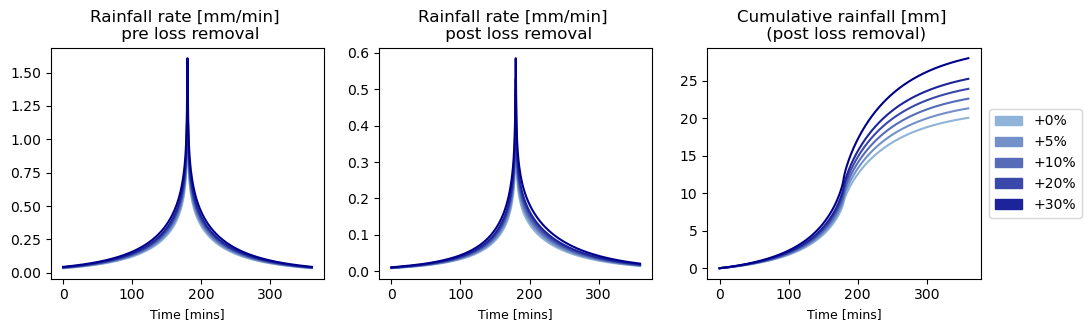

In [97]:
fig,axs=plt.subplots(1,3, figsize=(12,3))
for col_num, percent_increase in enumerate(percent_increases):
    if percent_increase=='05':
        percent_increase = 5
    # Read in post loss removal rainfall rate
    pre_loss_removal = pd.read_csv("{}/6hr_100yrRP/PreLossRemoval/6h_sp_+{}%volume.csv".format(catchment_name, percent_increase), names =['Time', 'Rain'])
    post_loss_removal = pd.read_csv("{}/6hr_100yrRP/PostLossRemoval/6h_sp_+{}%_urban.csv".format(catchment_name, percent_increase))
    # Find cumulative rainfall rate
    post_loss_removal['cumulative_rainfall_this_min'] = post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].cumsum()

    # PLot
    axs[0].plot(range(total_duration_minutes), pre_loss_removal['Rain'], color = colors[col_num])
    axs[0].set_xlabel('Time [mins]', fontsize = 9)
    axs[0].set_title('Rainfall rate [mm/min] \n pre loss removal')
    
    axs[1].plot(np.array(range(total_duration_minutes)) , post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'],
               colors[col_num])
    axs[1].set_xlabel('Time [mins]', fontsize = 9)
    axs[1].set_title('Rainfall rate [mm/min] \n post loss removal')
    
    axs[2].plot(np.array(range(total_duration_minutes)) , post_loss_removal['cumulative_rainfall_this_min'],
               colors[col_num])
    axs[2].set_xlabel('Time [mins]', fontsize = 9)
    axs[2].set_title('Cumulative rainfall [mm] \n (post loss removal)')
    
texts = ['+0%','+5%','+10%', '+20%' , '+30%'] 
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1, prop={'size': 10} )
#fig.savefig("{}/6hr_100yrRP/PostLossRemoval/Profile_plots.PNG".format(catchment_name));        

In [99]:
post_loss_removal = pd.read_csv("{}/6hr_100yrRP/PostLossRemoval/6h_sp_+{}%_urban.csv".format(catchment_name, '0'))
post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].sum()

20.067561685645092